# TSA with Prophet

[Prophet](https://facebook.github.io/prophet/) is open source software released by Facebook’s Core Data Science team. It is available for download on CRAN and PyPI.

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. According to Facebook, Prophet is "robust to outliers, missing data, and dramatic changes in your time series."

[Documentation](https://facebook.github.io/prophet/docs/quick_start.html)

## Prophet Quick Start Guide

1. [Install](https://facebook.github.io/prophet/docs/installation.html#python) the module.  

    - conda install plotly (or pip install plotly)
    - conda install pystan (or pip install pystan)
    - conda install -c conda-forge fbprophet (or pip install fbprophet)


2. Prepare your data: The data you run the Prophet algorithm on must be in a very specific shape with specific column names.  

    - dataframe    
    - 2 columns ONLY: `ds` and `y`    
    - `ds` is a datestamp column formatted as YYYY-MM-DD (date) or YYYY-MM-DD HH:MM:SS (timestamp)  
    - `y` must be numeric and represents the measurement we wish to forecast.   


3. Build a Prophet model (similary framework to the ML methods in Scikit-Learn). 
    
    - create an instance of the Prophet class
    - fit it to the training sample


4. Make predictions. 

    - Predict with with a single split, by creating a "future" dataframe with dates for which we want to make a prediction. 
    - Use cross_validation methods to predict


5. Evaluate predictions.

**Set up environment**

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from math import sqrt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_forecast_component

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
pd.plotting.register_matplotlib_converters()
import seaborn as sns

## Wrangle

In general, we need a **dataframe** with **2 columns**, **ds** (**datetime** datatype) and **y** (a **numeric** datatype), and sorted ascending by **ds**. We then need a dataframe for training.

Specifically, `ds` will be the `sale_date`, and `y` will represent dollars_sold = sale_amount * item_price. Our values will be resampled (or aggregated, grouped) by day.

To conclude our preparation, we will set the index of the dataframe to be `ds`. This is for splitting the data into train/test and visualizing. Note: before feeding the data into Prophet, we will need to reset that index so that `ds` is not the index, as required by Prophet.  

In [2]:
# acquire
df = pd.read_csv('store_item_demand.csv')

1. create our ds column = sale_date in datetime dtype
2. sort by date
3. create y = dollars sold = sale_amount x item_price
4. aggregate: daily sum of y, daily dollars sold across all stores and items.

In [3]:
# prep
def prep_data(df):
    return df.\
        assign(ds=pd.to_datetime(df.sale_date)).\
        sort_values('ds').\
        assign(y=df.sale_amount * df.item_price).\
        groupby(['ds'])['y'].sum().\
        reset_index().\
        set_index('ds')

df = prep_data(df)

Summarize our data

In [4]:
# number of rows
print(df.shape)

# First and last 2 rows
pd.concat([df.head(2), df.tail(2)])

(1826, 1)


,y
ds,
2013-01-01,73844.01
2013-01-02,73570.58
2017-12-30,134903.07
2017-12-31,140905.74


## Split Data

In [5]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

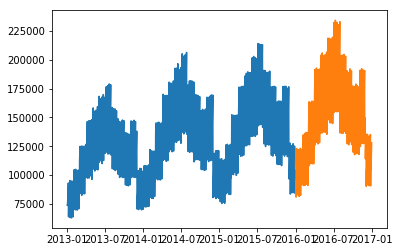

In [6]:
# verify train and validate dates by plotting
plt.plot(train)
plt.plot(validate)

Verify test dates by looking at dates included, so that we don't accidentally see some future data that may bias our modeling. 

In [7]:
print(test.shape)
pd.concat([test.head(2), test.tail(2)])

(365, 1)


,y
ds,
2017-01-01,127262.71
2017-01-02,85329.98
2017-12-30,134903.07
2017-12-31,140905.74


## Fit a Prophet Model

**Useful Hyperparameters** 

- Daily Seasonality: True/False    
- Growth Max: When forecasting growth, there is usually some maximum achievable point, e.g. total market size, total population size, etc. This is called the carrying capacity, and the forecast should saturate at this point. Prophet allows you to make forecasts using a logistic growth trend model, with a specified carrying capacity.    
- Saturating Min: The logistic growth model can also handle a saturating minimum, which is specified with a column floor in the same way as the cap column specifies the maximum.  
- Holidays: 
> Create a dataframe (2 columns: holiday, ds) for holidays or other recurring events to be modeled. We can also use the conventient Prophet function `add_country_holidays()` to set holidays. If you are creating a custom holidays dataframe, it must include the dates of all occurrences of the holiday beginning as far as the historical data go and continuing forward as far as the forecast is being made. `lower_window` and `upper_window` will extend the holiday out to [lower_window, upper_window] days around the date. For instance, if you wanted to include Christmas Eve in addition to Christmas you’d include lower_window=-1,upper_window=0.

In [8]:
# to use the growth max and saturating min, we add 2 columns, one for each...
# 'cap' and 'floor' with the respective values
train['cap'] = 250000
train['floor'] = 25000

# reset index as prophet needs ds to be a column and not an index. 
train = train.reset_index()
validate = validate.reset_index()
test = test.reset_index()

train.head(2)

,ds,y,cap,floor
0,2013-01-01,73844.01,250000,25000
1,2013-01-02,73570.58,250000,25000


- Daily seasonality = True
- Growth = Logistic (so it won't continue upward or downward indefinitely)
- Changepoint Range = .9
- Holidays = US holidays

In [10]:
import fbprophet
print(fbprophet.__version__)

0.4


In [11]:
m = Prophet(daily_seasonality = False,
            weekly_seasonality = True,
            growth = 'logistic',
            changepoint_range = 0.9)
# m.add_country_holidays(country_name='US')
# m.fit(train)

# print(m.train_holiday_names)

## Predict

Two ways to predict:   

1. create a `future` dataframe and create predictions for those dates. (This is basically your test dataframe)
2. use [Prophet's cross validation](https://facebook.github.io/prophet/docs/diagnostics.html) method to predict.  

### Using Future DataFrame

For making predictions with a Prophet model, we will use the Prophet function make_future_dataframe(). The argument we will provide is `periods`, the number of periods to make a prediction. In this case, our sampling frequency is daily, so our periods will be in terms of days. The make_future_dataframes() function, by default, will also include the dates from the original training dataset. We will also want our cap and floor included in the future dataframe. 

In [12]:
# future = m.make_future_dataframe(periods = len(validate))
# future['cap'] = 250000
# future['floor'] = 25000

Exception: Model must be fit before this can be used.

The futures dataframe will start with the first date in train and end with the last date in validate. Predictions will be made on all the days, but the model only used values of y up to the last date in train. 

In [11]:
# pd.concat([future.head(2), future.tail(2)])

,ds,cap,floor
0,2013-01-01,250000,25000
1,2013-01-02,250000,25000
1459,2016-12-30,250000,25000
1460,2016-12-31,250000,25000


The `predict` method will assign each row in `future` a predicted value, `yhat`. If you pass in historical dates, it will provide an in-sample fit. The `forecast` object that is returned is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals (`yhat_lower` and `yhat_upper`)

In [12]:
# forecast = m.predict(future)

Take a look at the columns that are returned. 

In [13]:
# forecast.columns

Take a look at the predictions made on holidays. 

In [14]:
# select the dates for the holidays listed, and extract the sales predictions during those holidays
# forecast[(forecast['Christmas Day'] + 
#           forecast['Thanksgiving'] + 
#           forecast["New Year's Day"]).abs() > 0]\
#         [['ds', 
#           'Christmas Day', 
#           'Thanksgiving', 
#           "New Year's Day"]][-10:]

,ds,Christmas Day,Thanksgiving,New Year's Day
358,2013-12-25,1490.560679,0.000000,0.00000
365,2014-01-01,0.000000,0.000000,1758.01848
695,2014-11-27,0.000000,14048.758686,0.00000
723,2014-12-25,1490.560679,0.000000,0.00000
730,2015-01-01,0.000000,0.000000,1758.01848
1059,2015-11-26,0.000000,14048.758686,0.00000
1088,2015-12-25,1490.560679,0.000000,0.00000
1095,2016-01-01,0.000000,0.000000,1758.01848
1423,2016-11-24,0.000000,14048.758686,0.00000
1454,2016-12-25,1490.560679,0.000000,0.00000


Peek into the last predictions, including the confidence interval. 

In [14]:
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

**Evaluate**

We can evaluate by compute the RMSE.  

In [15]:
# from sklearn.metrics import mean_squared_error

# eval_df = pd.merge(df, forecast[['ds', 'yhat']], how = 'inner', on = 'ds')

# rmse = sqrt(mean_squared_error(eval_df.y, eval_df.yhat))
# rmse

**Visualize Predictions**

In [16]:
# fig1 = m.plot(forecast)

To see the forecast components, we can call Prophet.plot_components(). By default we'll see the trend, yearly seasonality, and weekly seasonality of the time series. We can opt to include holidays, also.

In [17]:
# fig2 = m.plot_components(forecast, 'holidays')

### Using Cross Validation

Use the cross_validation() function on the model and specify the forecast horizon with the horizon parameter. 

In [18]:
# format for initial, period and horizon should be in format 
# used by pandas timedelta, which accepts units of days or shorter. 

# df_cv = cross_validation(m, 
#                          initial = '730 days', 
#                          period = '90 days', 
#                          horizon = '180 days', 
#                         )
# df_cv.head()

**What are the cutoff dates?**

You will see there are 3 cutoff dates, with 180 observations related to each. The cutoff date respresents the last day of the observation period and the 180 days are the 180 horizon days that follow that cutoff date. Cutoff date 2 will be 90 days (i.e. the "period" parameter) beyond cutoff date 1. 


In [19]:
# df_cv.cutoff.value_counts()

**Evaluate**

In [20]:
# df_p = performance_metrics(df_cv)
# df_p.head(5)

In [21]:
# df_p[df_p.horizon == "60 days"]

**Visualize**  

We can also plot the Mean Absolute Percent Error (MAPE) over the forecast horizon to determine whether our forecast is trustworthy. Here, we use a percentage error instead of the Mean Squared Error (MSE), simply because it is easier to interpret.

In [22]:
# plot_forecast_component(m, forecast, 'yhat')

In [23]:
# fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

In [24]:
# fig3 = plot_cross_validation_metric(df_cv, metric='mape')

The blue line represents the metric. 
In the case of MAPE, the mean is taken over a rolling window of the dots. Here, we are erroring around 5% pretty consistently across the horizon. We can change the size of the rollling window with the arguement rolling_window, which specifies the proportion of forecasts to use in each rolling window. The default is .1, or 10% of the rows from df_cv. A larger rolling window will create a smoother curve. 